In [10]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import warnings
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split

from dataScipy import DataScience as DS

# READ DATA

In [2]:
DATA_FOLDER_PATH = os.getcwd() + '/../data/KS VERI/'
FILE_NAME = 'KS10_FINAL_DATA.csv'
PATH = DATA_FOLDER_PATH + FILE_NAME
FINAL_DF = pd.read_csv(PATH, header=0)
FINAL_DF['Timestamp'] = pd.to_datetime(FINAL_DF['Timestamp'])
FINAL_DF

,Timestamp,PUE,I_KOMP1_HIZ,I_KOMP1_SAAT,I_KOMP2_HIZ,I_KOMP2_SAAT,I_NEM_SET,I_SIC_SET,II_KOMP1_HIZ,II_KOMP1_SAAT,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
0,2023-04-01 00:00:00,1.593893,25.000000,8968.0,0.0,3.0,45.0,23.0,36.200001,12770.0,...,0,0,1,0,0,0,0,0,0,0
1,2023-04-01 00:05:00,1.623764,45.200001,8968.0,0.0,3.0,45.0,23.0,34.000000,12770.0,...,0,0,1,0,0,0,0,0,0,0
2,2023-04-01 00:10:00,1.634981,25.700001,8968.0,0.0,3.0,45.0,23.0,34.700001,12770.0,...,0,0,1,0,0,0,0,0,0,0
3,2023-04-01 00:15:00,1.608970,28.400000,8968.0,0.0,3.0,45.0,23.0,39.900002,12770.0,...,0,0,1,0,0,0,0,0,0,0
4,2023-04-01 00:20:00,1.554008,28.000000,8968.0,0.0,3.0,45.0,23.0,36.900002,12770.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59625,2023-10-25 00:45:00,1.611181,26.400000,13761.0,0.0,3.0,45.0,22.0,0.000000,17241.0,...,0,0,0,0,0,0,0,0,1,0
59626,2023-10-25 00:50:00,1.831158,39.200001,13761.0,0.0,3.0,45.0,22.0,49.700001,17241.0,...,0,0,0,0,0,0,0,0,1,0
59627,2023-10-25 00:55:00,1.627907,44.000000,13761.0,0.0,3.0,45.0,22.0,0.000000,17241.0,...,0,0,0,0,0,0,0,0,1,0
59628,2023-10-25 01:00:00,1.590126,0.000000,13761.0,0.0,3.0,45.0,22.0,29.400000,17241.0,...,0,0,0,0,0,0,0,0,1,0


In [41]:
FINAL_DF.columns

Index(['Timestamp', 'PUE', 'I_KOMP1_HIZ', 'I_KOMP1_SAAT', 'I_KOMP2_HIZ',
       'I_KOMP2_SAAT', 'I_NEM_SET', 'I_SIC_SET', 'II_KOMP1_HIZ',
       'II_KOMP1_SAAT', 'II_KOMP2_HIZ', 'II_KOMP2_SAAT', 'II_NEM_SET',
       'II_SIC_SET', 'III_KOMP1_HIZ', 'III_KOMP1_SAAT', 'III_KOMP2_HIZ',
       'III_KOMP2_SAAT', 'III_NEM_SET', 'III_SIC_SET', 'IV_KOMP1_HIZ',
       'IV_KOMP1_SAAT', 'IV_KOMP2_HIZ', 'IV_KOMP2_SAAT', 'IV_NEM_SET',
       'CH1_CIKIS_SIC', 'CH1_GIRIS_SIC', 'CH2_CIKIS_SIC', 'CH2_GIRIS_SIC',
       'CH3_CIKIS_SIC', 'CH3_GIRIS_SIC', 'SENSOR_I_TEMP', 'SENSOR_II_TEMP',
       'OUTLET_TEMP', 'OUTLET_HUMIDITY', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri',
       'Sat', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5'

# DATA VISUALIZATION

## PUE

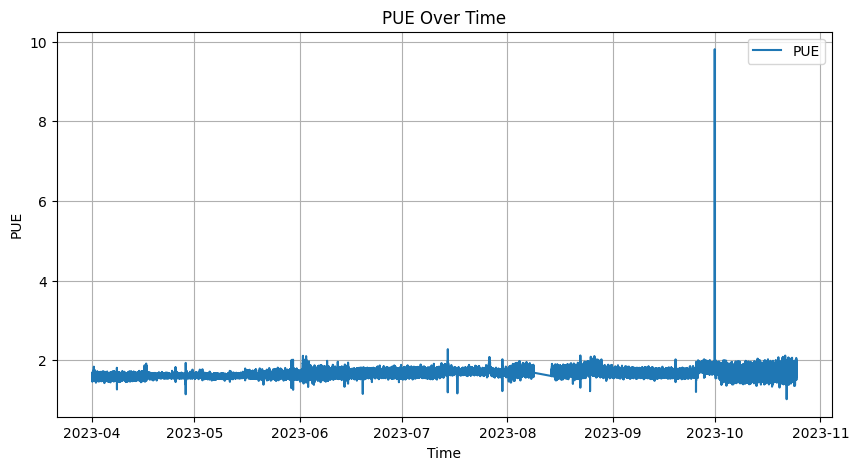

In [3]:
plt.figure(figsize=(10, 5))

plt.plot(FINAL_DF['Timestamp'],FINAL_DF['PUE'], label='PUE')

plt.title('PUE Over Time')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.grid()

plt.legend()
plt.show()

## PUE ELIMINATE OUTLIERS

In [5]:
# Calculate lower and upper bounds
lower_bound = 1
upper_bound = 2.5
print('Lower Bound: ', lower_bound)
print('Upper Bound: ', upper_bound)

# Detect outliers
outliers = FINAL_DF[(FINAL_DF['PUE'] < lower_bound) | (FINAL_DF['PUE'] > upper_bound)]
print('Number of Outliers: ', outliers.shape[0])
print('Outliers: ')
outliers

Lower Bound:  1
Upper Bound:  2.5
Number of Outliers:  1
Outliers: 


,Timestamp,PUE,I_KOMP1_HIZ,I_KOMP1_SAAT,I_KOMP2_HIZ,I_KOMP2_SAAT,I_NEM_SET,I_SIC_SET,II_KOMP1_HIZ,II_KOMP1_SAAT,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
52693,2023-09-30 23:05:00,9.808001,49.700001,13238.0,0.0,3.0,45.0,22.0,49.700001,17012.0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# REPLACE OUTLIERS WITH THE MEAN OF THE PREVIOUS AND NEXT VALUES
for index, row in outliers.iterrows():
    if index == 0:
        FINAL_DF.loc[index, 'PUE'] = FINAL_DF.loc[index + 1, 'PUE']
    elif index == FINAL_DF.shape[0] - 1:
        FINAL_DF.loc[index, 'PUE'] = FINAL_DF.loc[index - 1, 'PUE']
    else:
        FINAL_DF.loc[index, 'PUE'] = (FINAL_DF.loc[index - 1, 'PUE'] + FINAL_DF.loc[index + 1, 'PUE']) / 2

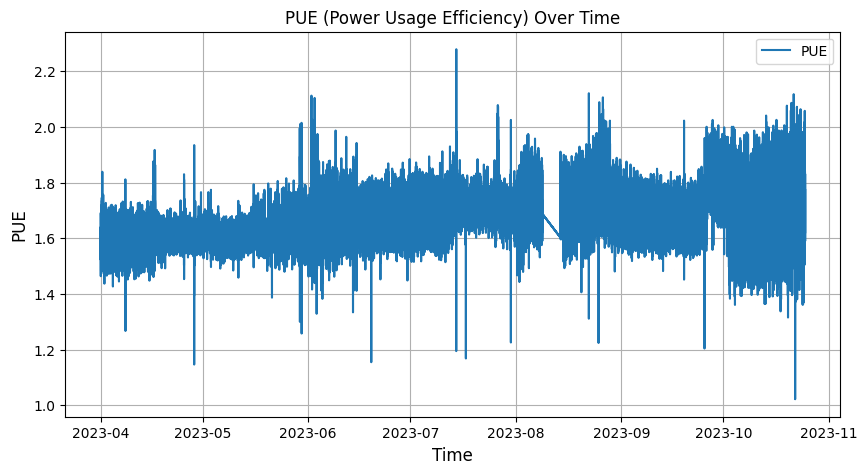

In [74]:
plt.figure(figsize=(10, 5))

plt.plot(FINAL_DF['Timestamp'],FINAL_DF['PUE'], label='PUE')

plt.title('PUE (Power Usage Efficiency) Over Time')
plt.xlabel('Time', fontsize=12)
plt.ylabel('PUE', fontsize=12)
plt.grid()

plt.legend()
plt.show()

## KS10.1

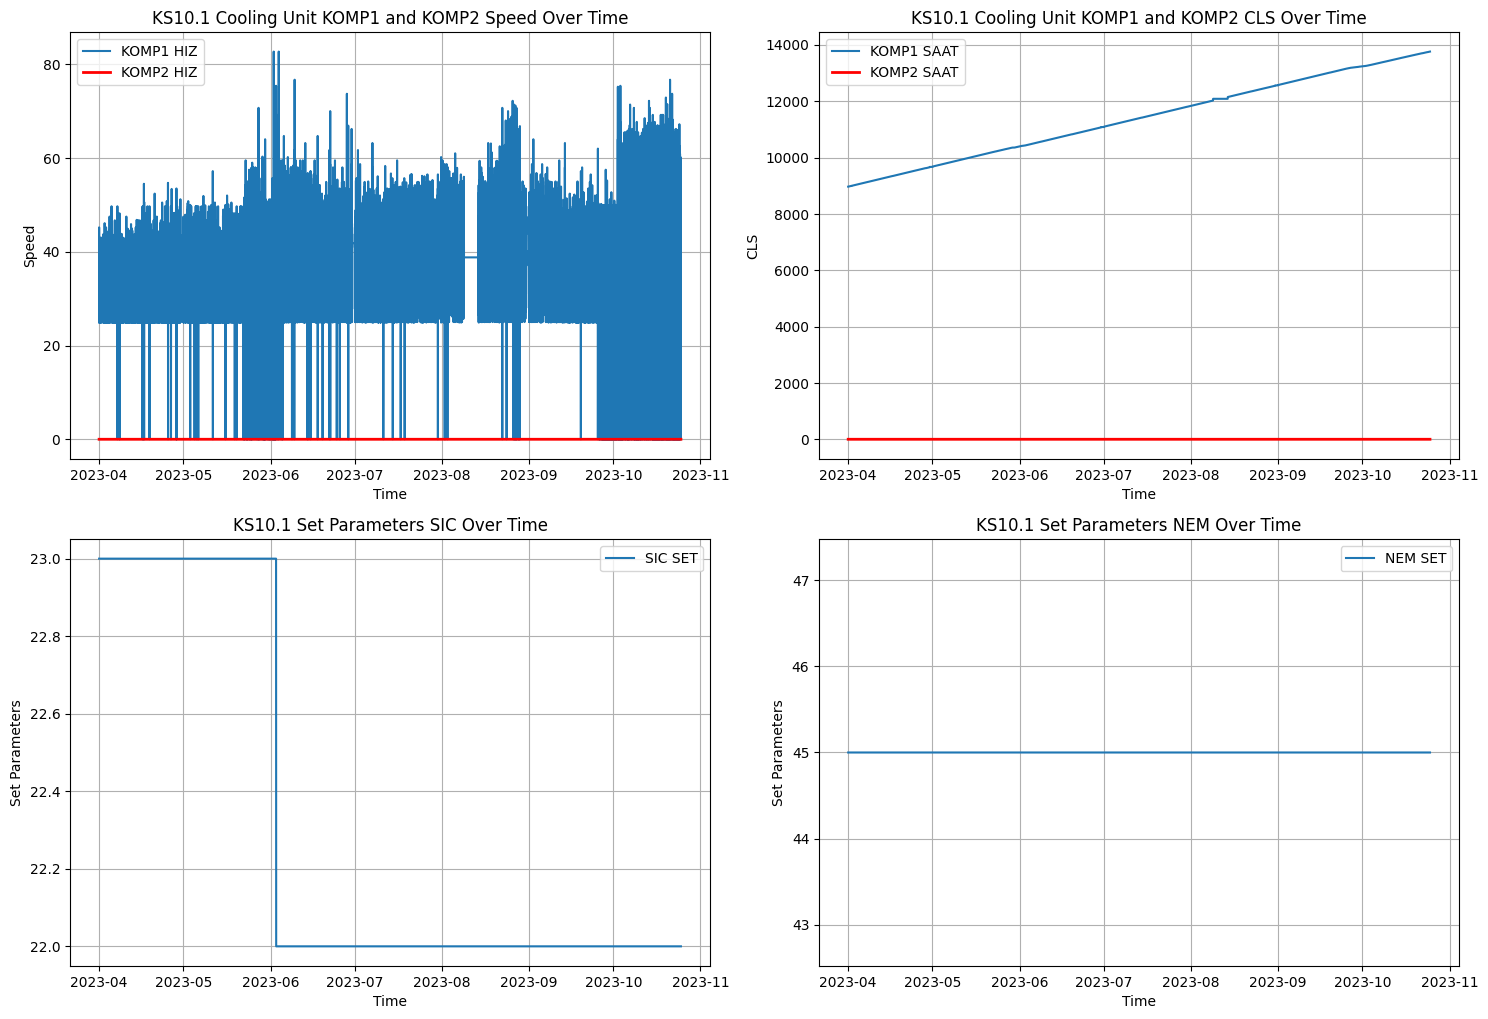

In [31]:
# plot everything about KS10.1 with subplots FOR EACH ROW FOR SUBPLOTS PLOT 2 GRAPHS
plt.figure(figsize=(15, 20))

# Subplot for KS10.1 Cooling Unit Speed for KOMP1
plt.subplot(4, 2, 1)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['I_KOMP1_HIZ'], label='KOMP1 HIZ')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['I_KOMP2_HIZ'], label='KOMP2 HIZ', color='r', linewidth=2)
plt.title('KS10.1 Cooling Unit KOMP1 and KOMP2 Speed Over Time')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.grid()
plt.legend()

# Subplot for KS10.1 Cooling Unit CLS for KOMP1
plt.subplot(4, 2, 2)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['I_KOMP1_SAAT'], label='KOMP1 SAAT')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['I_KOMP2_SAAT'], label='KOMP2 SAAT', color='r', linewidth=2)
plt.title('KS10.1 Cooling Unit KOMP1 and KOMP2 CLS Over Time')
plt.xlabel('Time')
plt.ylabel('CLS')
plt.grid()
plt.legend()

# Subplot for KS10.1 Cooling Unit Set Parameters SIC
plt.subplot(4, 2, 3)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['I_SIC_SET'], label='SIC SET')
plt.title('KS10.1 Set Parameters SIC Over Time')
plt.xlabel('Time')
plt.ylabel('Set Parameters')
plt.grid()
plt.legend()

# Subplot for KS10.1 Cooling Unit Set Parameters NEM
plt.subplot(4, 2, 4)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['I_NEM_SET'], label='NEM SET')
plt.title('KS10.1 Set Parameters NEM Over Time')
plt.xlabel('Time')
plt.ylabel('Set Parameters')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## KS10.2

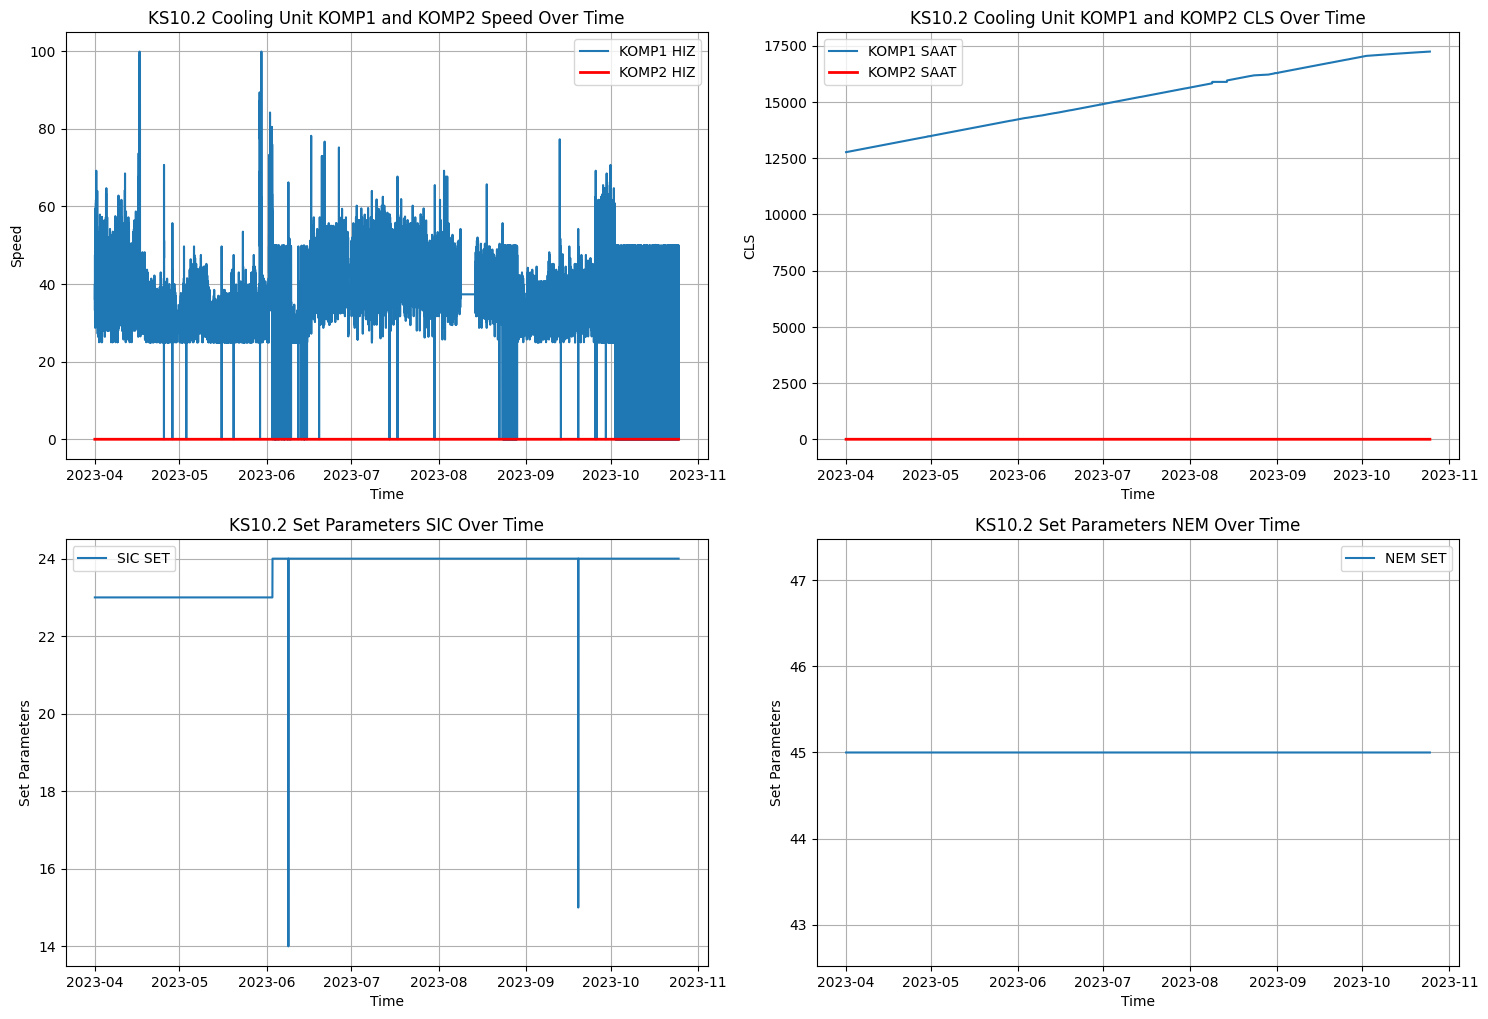

In [32]:
# plot everything about KS10.2 with subplots FOR EACH ROW FOR SUBPLOTS PLOT 2 GRAPHS
plt.figure(figsize=(15, 20))

# Subplot for KS10.1 Cooling Unit Speed for KOMP1
plt.subplot(4, 2, 1)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['II_KOMP1_HIZ'], label='KOMP1 HIZ')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['II_KOMP2_HIZ'], label='KOMP2 HIZ', color='r', linewidth=2)
plt.title('KS10.2 Cooling Unit KOMP1 and KOMP2 Speed Over Time')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.grid()
plt.legend()

# Subplot for KS10.1 Cooling Unit CLS for KOMP1
plt.subplot(4, 2, 2)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['II_KOMP1_SAAT'], label='KOMP1 SAAT')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['II_KOMP2_SAAT'], label='KOMP2 SAAT', color='r', linewidth=2)
plt.title('KS10.2 Cooling Unit KOMP1 and KOMP2 CLS Over Time')
plt.xlabel('Time')
plt.ylabel('CLS')
plt.grid()
plt.legend()

# Subplot for KS10.1 Cooling Unit Set Parameters SIC
plt.subplot(4, 2, 3)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['II_SIC_SET'], label='SIC SET')
plt.title('KS10.2 Set Parameters SIC Over Time')
plt.xlabel('Time')
plt.ylabel('Set Parameters')
plt.grid()
plt.legend()

# Subplot for KS10.1 Cooling Unit Set Parameters NEM
plt.subplot(4, 2, 4)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['II_NEM_SET'], label='NEM SET')
plt.title('KS10.2 Set Parameters NEM Over Time')
plt.xlabel('Time')
plt.ylabel('Set Parameters')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## KS10.3

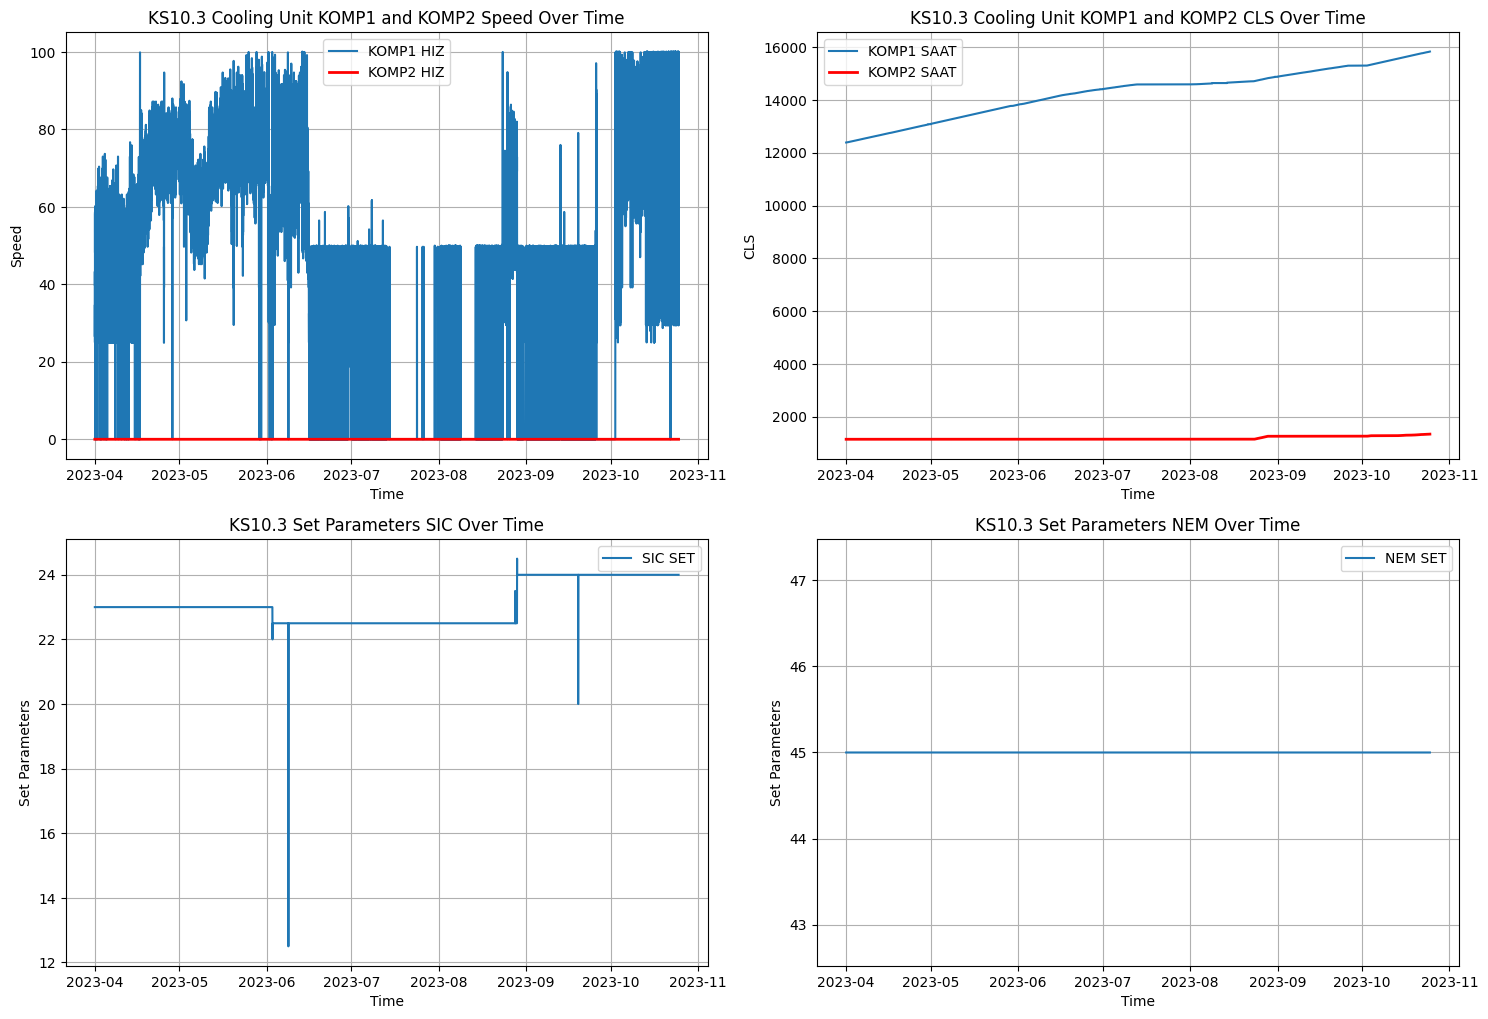

In [33]:
# plot everything about KS10.2 with subplots FOR EACH ROW FOR SUBPLOTS PLOT 2 GRAPHS
plt.figure(figsize=(15, 20))

# Subplot for KS10.1 Cooling Unit Speed for KOMP1
plt.subplot(4, 2, 1)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['III_KOMP1_HIZ'], label='KOMP1 HIZ')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['III_KOMP2_HIZ'], label='KOMP2 HIZ', color='r', linewidth=2)
plt.title('KS10.3 Cooling Unit KOMP1 and KOMP2 Speed Over Time')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.grid()
plt.legend()

# Subplot for KS10.1 Cooling Unit CLS for KOMP1
plt.subplot(4, 2, 2)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['III_KOMP1_SAAT'], label='KOMP1 SAAT')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['III_KOMP2_SAAT'], label='KOMP2 SAAT', color='r', linewidth=2)
plt.title('KS10.3 Cooling Unit KOMP1 and KOMP2 CLS Over Time')
plt.xlabel('Time')
plt.ylabel('CLS')
plt.grid()
plt.legend()

# Subplot for KS10.1 Cooling Unit Set Parameters SIC
plt.subplot(4, 2, 3)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['III_SIC_SET'], label='SIC SET')
plt.title('KS10.3 Set Parameters SIC Over Time')
plt.xlabel('Time')
plt.ylabel('Set Parameters')
plt.grid()
plt.legend()

# Subplot for KS10.1 Cooling Unit Set Parameters NEM
plt.subplot(4, 2, 4)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['III_NEM_SET'], label='NEM SET')
plt.title('KS10.3 Set Parameters NEM Over Time')
plt.xlabel('Time')
plt.ylabel('Set Parameters')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## KS10.4

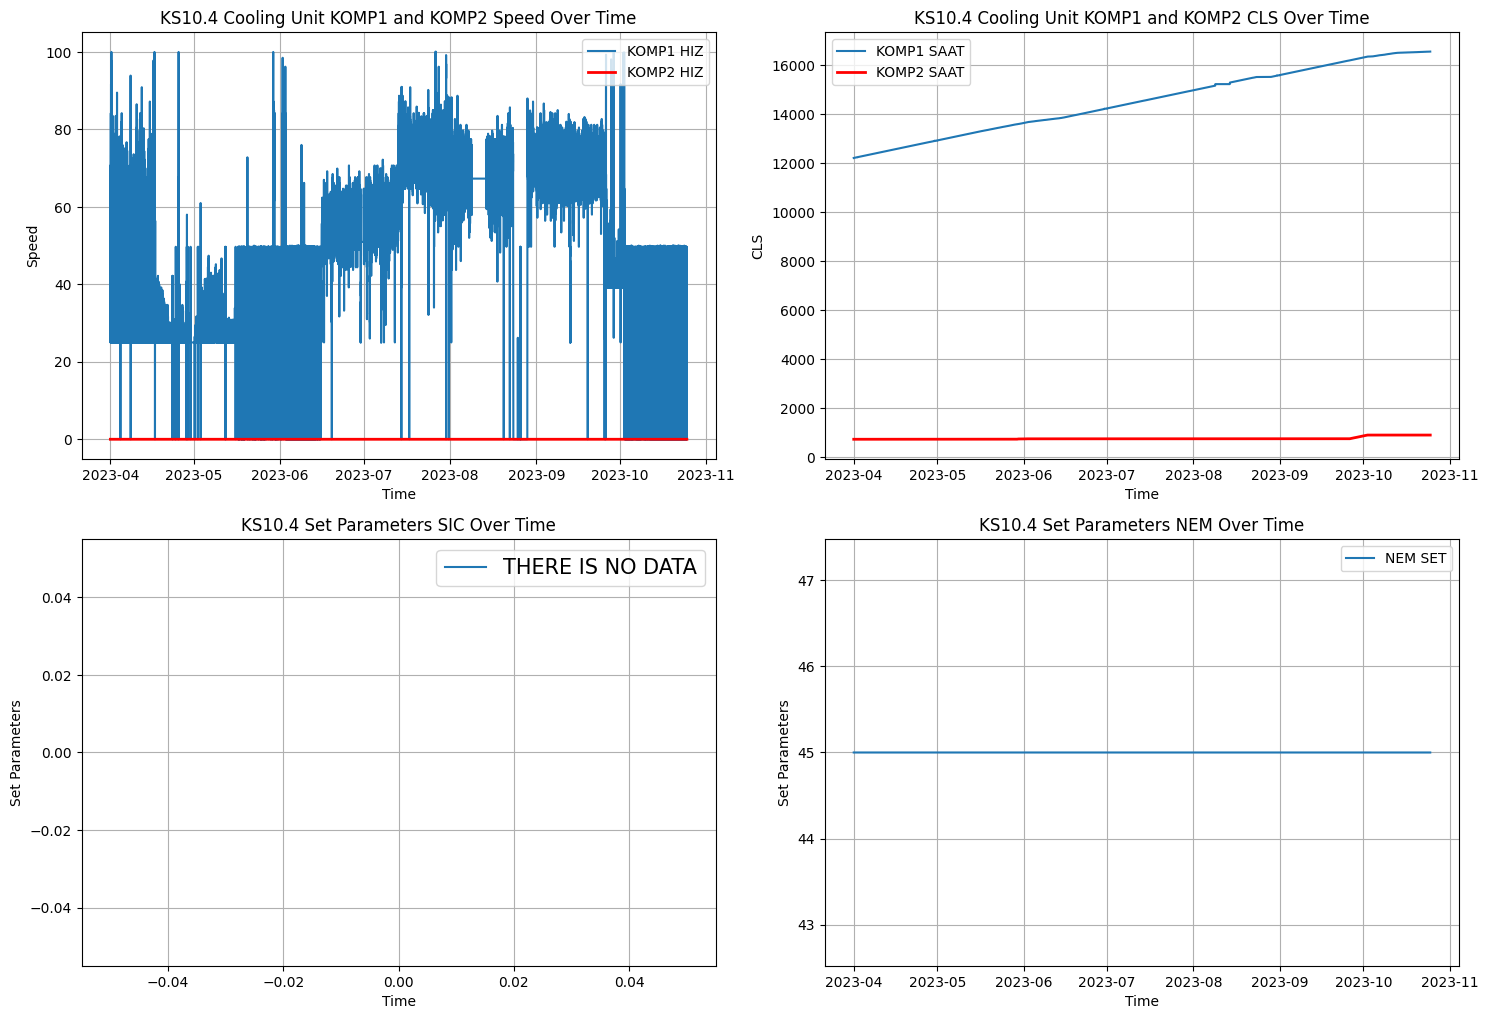

In [40]:
# plot everything about KS10.2 with subplots FOR EACH ROW FOR SUBPLOTS PLOT 2 GRAPHS
plt.figure(figsize=(15, 20))

# Subplot for KS10.1 Cooling Unit Speed for KOMP1
plt.subplot(4, 2, 1)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['IV_KOMP1_HIZ'], label='KOMP1 HIZ')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['IV_KOMP2_HIZ'], label='KOMP2 HIZ', color='r', linewidth=2)
plt.title('KS10.4 Cooling Unit KOMP1 and KOMP2 Speed Over Time')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.grid()
plt.legend()

# Subplot for KS10.1 Cooling Unit CLS for KOMP1
plt.subplot(4, 2, 2)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['IV_KOMP1_SAAT'], label='KOMP1 SAAT')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['IV_KOMP2_SAAT'], label='KOMP2 SAAT', color='r', linewidth=2)
plt.title('KS10.4 Cooling Unit KOMP1 and KOMP2 CLS Over Time')
plt.xlabel('Time')
plt.ylabel('CLS')
plt.grid()
plt.legend()

# Subplot for KS10.1 Cooling Unit Set Parameters SIC
# because there is no data for KS10.4 SIC SET write 'THERE IS NO DATA' in the plot
# do not plot anything
plt.subplot(4, 2, 3)
plt.plot([], [], label='THERE IS NO DATA')
plt.title('KS10.4 Set Parameters SIC Over Time')
plt.xlabel('Time')
plt.ylabel('Set Parameters')
plt.grid()
plt.legend(fontsize=15)

# Subplot for KS10.1 Cooling Unit Set Parameters NEM
plt.subplot(4, 2, 4)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['IV_NEM_SET'], label='NEM SET')
plt.title('KS10.4 Set Parameters NEM Over Time')
plt.xlabel('Time')
plt.ylabel('Set Parameters')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## CHILLER PLOT

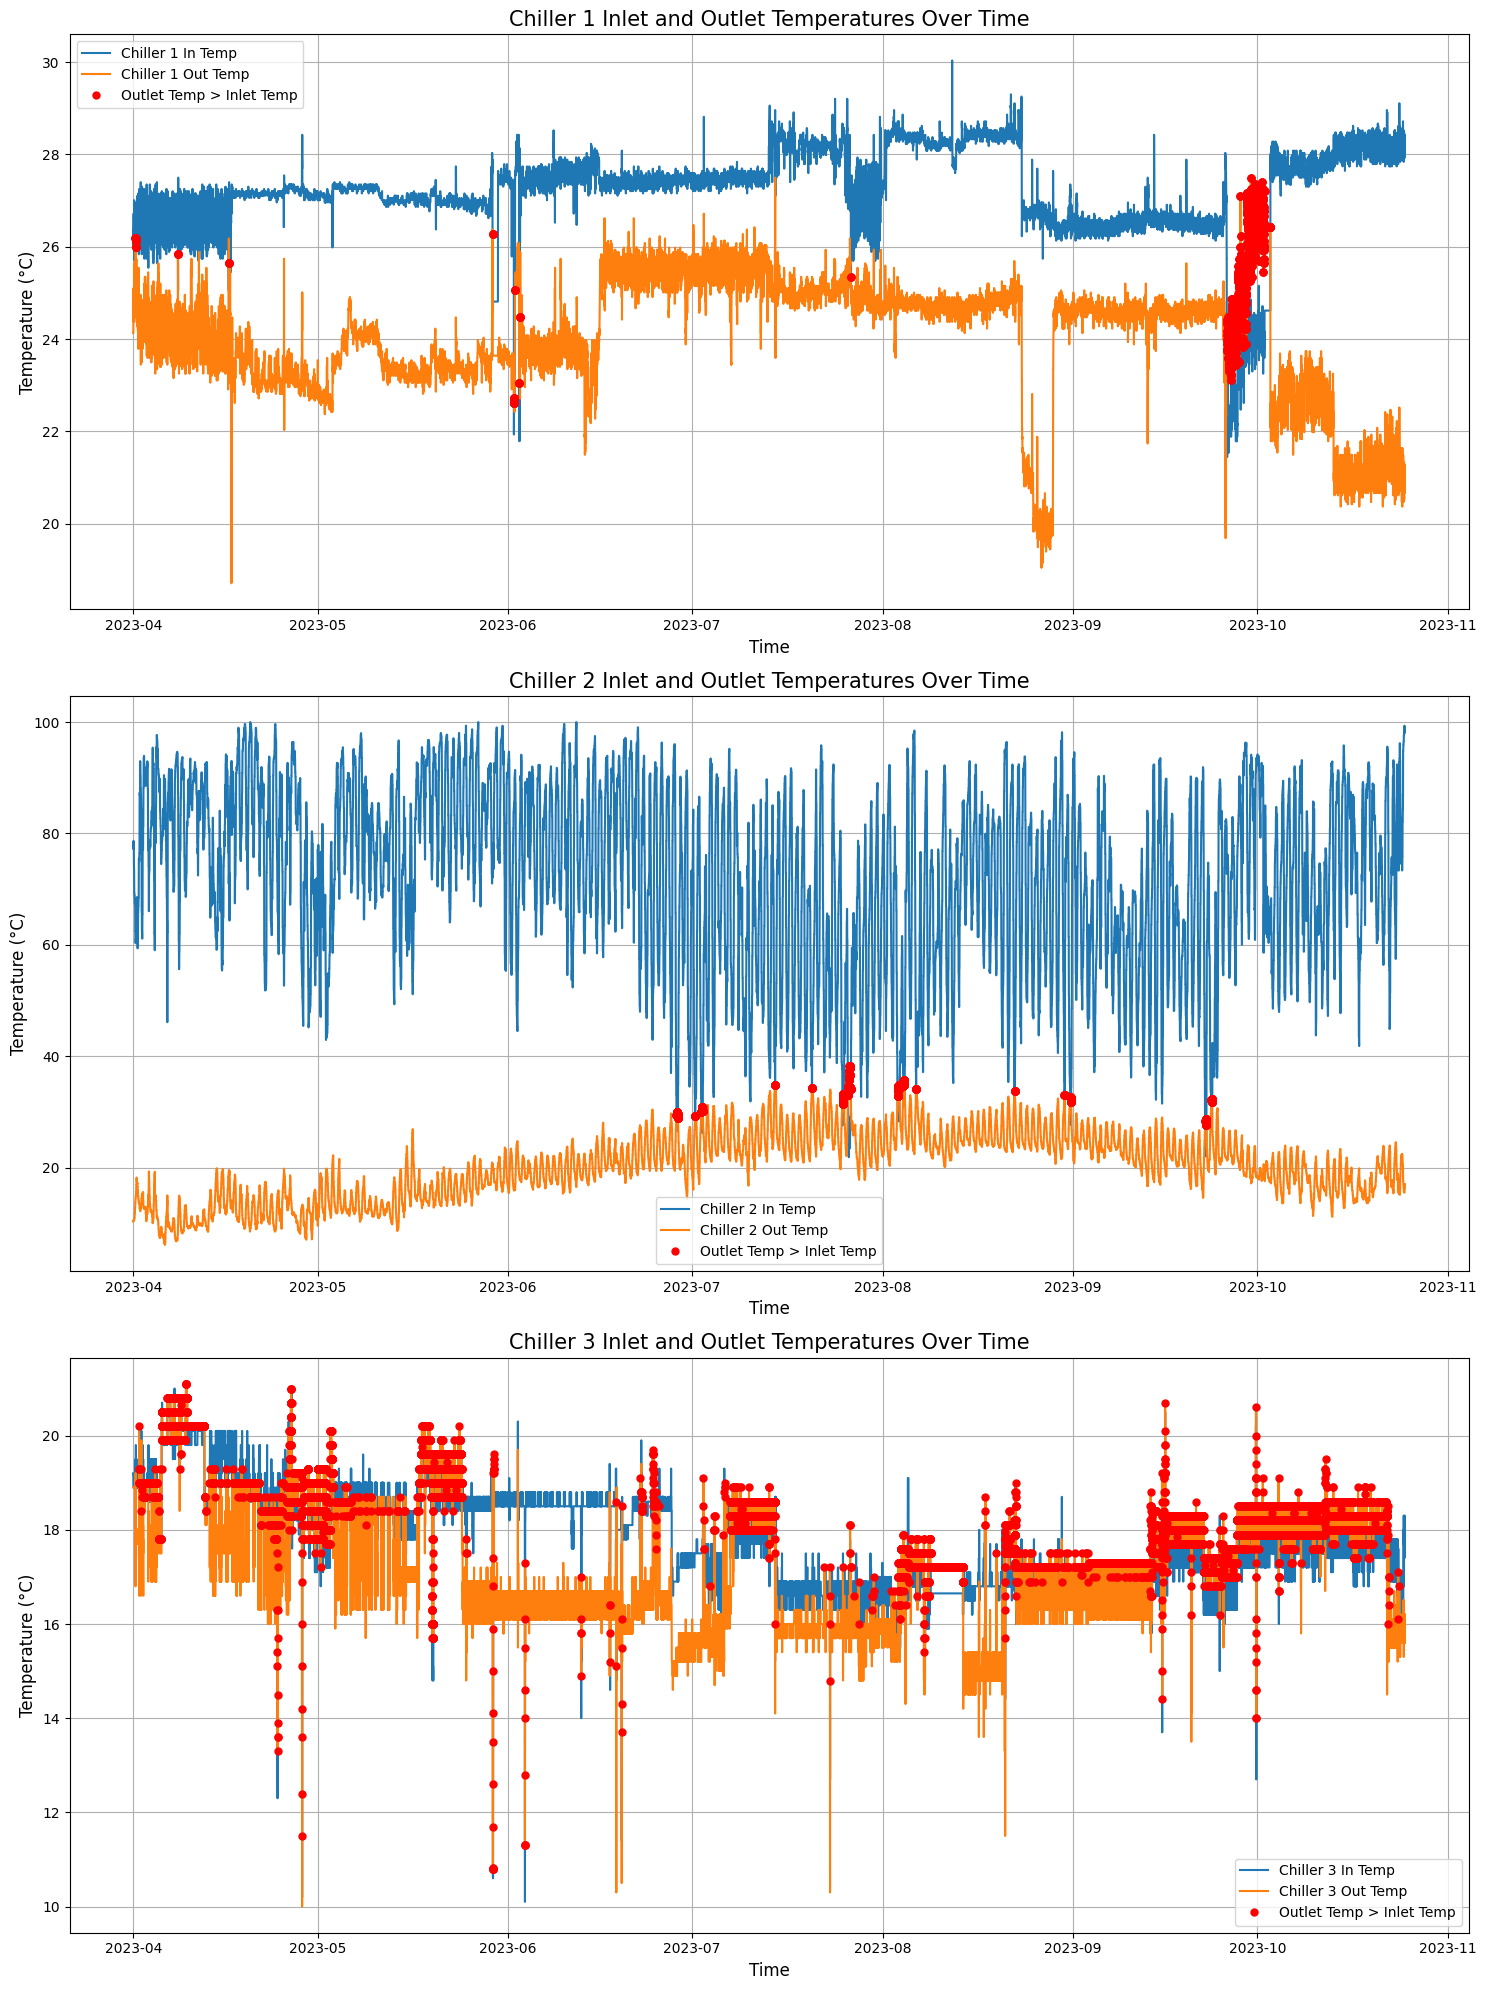

In [67]:
# plot everything about CHILLER with subplots in one col
plt.figure(figsize=(15, 20))

# Subplot for Chiller 1 Temperatures
plt.subplot(3, 1, 1)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH1_GIRIS_SIC'], label='Chiller 1 In Temp')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH1_CIKIS_SIC'], label='Chiller 1 Out Temp')
# plot a dot where inlet temperature is higher than outlet temperature
plt.plot(FINAL_DF.loc[FINAL_DF['CH1_GIRIS_SIC'] < FINAL_DF['CH1_CIKIS_SIC'], 'Timestamp'], 
         FINAL_DF.loc[FINAL_DF['CH1_GIRIS_SIC'] < FINAL_DF['CH1_CIKIS_SIC'], 'CH1_CIKIS_SIC'], 
         'ro', label='Outlet Temp > Inlet Temp', ms=5)

plt.title('Chiller 1 Inlet and Outlet Temperatures Over Time', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid()
plt.legend()

# Subplot for Chiller 2 Temperatures
plt.subplot(3, 1, 2)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH2_GIRIS_SIC'], label='Chiller 2 In Temp')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH2_CIKIS_SIC'], label='Chiller 2 Out Temp')
# plot a dot where inlet temperature is higher than outlet temperature
plt.plot(FINAL_DF.loc[FINAL_DF['CH2_GIRIS_SIC'] < FINAL_DF['CH2_CIKIS_SIC'], 'Timestamp'], 
         FINAL_DF.loc[FINAL_DF['CH2_GIRIS_SIC'] < FINAL_DF['CH2_CIKIS_SIC'], 'CH2_CIKIS_SIC'], 
         'ro', label='Outlet Temp > Inlet Temp', ms=5)
plt.title('Chiller 2 Inlet and Outlet Temperatures Over Time', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid()
plt.legend()

# Subplot for Chiller 3 Temperatures
plt.subplot(3, 1, 3)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH3_GIRIS_SIC'], label='Chiller 3 In Temp')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['CH3_CIKIS_SIC'], label='Chiller 3 Out Temp')
# plot a dot where inlet temperature is higher than outlet temperature
plt.plot(FINAL_DF.loc[FINAL_DF['CH3_GIRIS_SIC'] < FINAL_DF['CH3_CIKIS_SIC'], 'Timestamp'], 
         FINAL_DF.loc[FINAL_DF['CH3_GIRIS_SIC'] < FINAL_DF['CH3_CIKIS_SIC'], 'CH3_CIKIS_SIC'], 
         'ro', label='Outlet Temp > Inlet Temp', ms=5)
plt.title('Chiller 3 Inlet and Outlet Temperatures Over Time', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## SENSOR PLOT

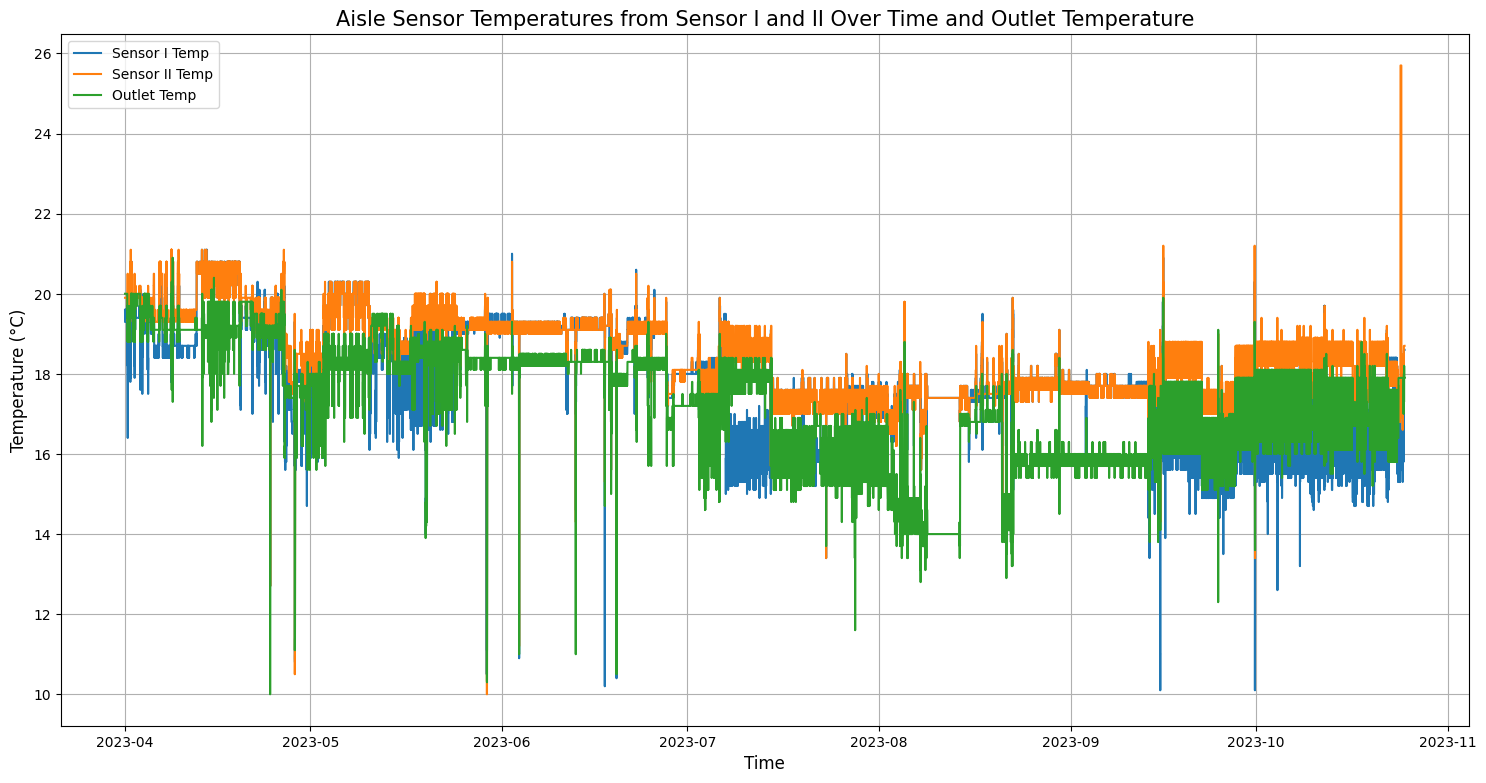

In [73]:
# plot everything about SENSOR with subplots in one col
plt.figure(figsize=(15, 15))

# Subplot for Sensor 1 and 2 Temperatures
plt.subplot(2, 1, 1)
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['SENSOR_I_TEMP'], label='Sensor I Temp')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['SENSOR_II_TEMP'], label='Sensor II Temp')
plt.plot(FINAL_DF['Timestamp'], FINAL_DF['OUTLET_TEMP'], label='Outlet Temp')
plt.title('Aisle Sensor Temperatures from Sensor I and II Over Time and Outlet Temperature', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()